In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k

###################################
# TensorFlow wizardry
config = tf.ConfigProto()

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1 # 0.5 for Half

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))


Using TensorFlow backend.


In [2]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model

import tensorflow as tf
import keras
import seaborn as sn
import pandas as pd
import numpy as np
import linecache
import sys
import h5py
import itertools
import matplotlib.pyplot as plt
import os
import pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
tf.__version__

'1.9.0'

In [5]:
train_path = '/data/danish/Data/Malimg-Color-25-Families/Malimg-Colorimage-train/'
test_path  = '/data/danish/Data/Malimg-Color-25-Families/Malimg-Colorimage-test/'

In [6]:
datagen_train = ImageDataGenerator(
      rescale=1./255#,
      #rotation_range=0.1,#180,
      #width_shift_range=0.1,
      #height_shift_range=0.1,
      #shear_range=0.1,
      #zoom_range=0.1,#[0.9, 1.5],
      #horizontal_flip=True,
      #vertical_flip=True,
      #fill_mode='nearest'
                )

datagen_test = ImageDataGenerator(rescale=1./255)


In [15]:
if False:
    save_to_dir='augmented_images/'
else:
    save_to_dir = None

In [16]:
input_shape=(224,224)
batch_size=32
save_fn='Deep_Learning_Model_for_Malimg_size_GrayScale='+str(input_shape[:])
save_fn

'Deep_Learning_Model_for_Malimg_size_GrayScale=(224, 224)'

In [17]:
generator_train = datagen_train.flow_from_directory(directory=train_path,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',#binary
                                                    color_mode="rgb",
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir,
                                                    seed=42)


steps_train = generator_train.n/ batch_size
print("Steps for Training",steps_train)

cls_train = generator_train.classes
print(cls_train)
cls_names_train = list(generator_train.class_indices.keys())
print(cls_names_train)
num_cls_train = len(cls_names_train)
print("Number of Classes in Training Data",num_cls_train)

Found 6527 images belonging to 25 classes.
Steps for Training 203.96875
[ 0  0  0 ..., 24 24 24]
['AdialerC', 'AgentFYI', 'AllapleA', 'AllapleL', 'Aluerongen!J', 'AutorunK', 'C2LOPP', 'C2LOPgen!g', 'DialplatformB', 'DontovoA', 'Fakerean', 'Instantaccess', 'LolydaAA1', 'LolydaAA2', 'LolydaAA3', 'LolydaAT', 'Malexgen!J', 'ObfuscatorAD', 'Rbot!gen', 'SkintrimN', 'Swizzorgen!E', 'Swizzorgen!I', 'VBAT', 'WintrimBX', 'YunerA']
Number of Classes in Training Data 25


In [18]:
from sklearn.utils.class_weight import compute_class_weight
class_weight_train = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

In [19]:
#cls_names_train
class_labels = ['AdialerC','AgentFYI','AllapleA','AllapleL','Aluerongen!J','AutorunK','C2LOPP','C2LOPgen!g','DialplatformB','DontovoA',
 'Fakerean','Instantaccess','LolydaAA1','LolydaAA2','LolydaAA3','LolydaAT','Malexgen!J','ObfuscatorAD','Rbot!gen','SkintrimN',
 'Swizzorgen!E','Swizzorgen!I','VBAT','WintrimBX','YunerA']
class_labels

['AdialerC',
 'AgentFYI',
 'AllapleA',
 'AllapleL',
 'Aluerongen!J',
 'AutorunK',
 'C2LOPP',
 'C2LOPgen!g',
 'DialplatformB',
 'DontovoA',
 'Fakerean',
 'Instantaccess',
 'LolydaAA1',
 'LolydaAA2',
 'LolydaAA3',
 'LolydaAT',
 'Malexgen!J',
 'ObfuscatorAD',
 'Rbot!gen',
 'SkintrimN',
 'Swizzorgen!E',
 'Swizzorgen!I',
 'VBAT',
 'WintrimBX',
 'YunerA']

In [20]:
class_weight_train

array([ 3.07152941,  3.22320988,  0.12649225,  0.23457323,  1.89188406,
        3.52810811,  2.55960784,  1.86485714,  2.12260163,  2.31044248,
        0.98150376,  0.86737542,  1.75221477,  2.0396875 ,  3.03581395,
        2.35207207,  2.74821053,  2.63717172,  2.37345455,  4.66214286,
        2.93348315,  2.83782609,  0.91607018,  3.89671642,  0.46621429])

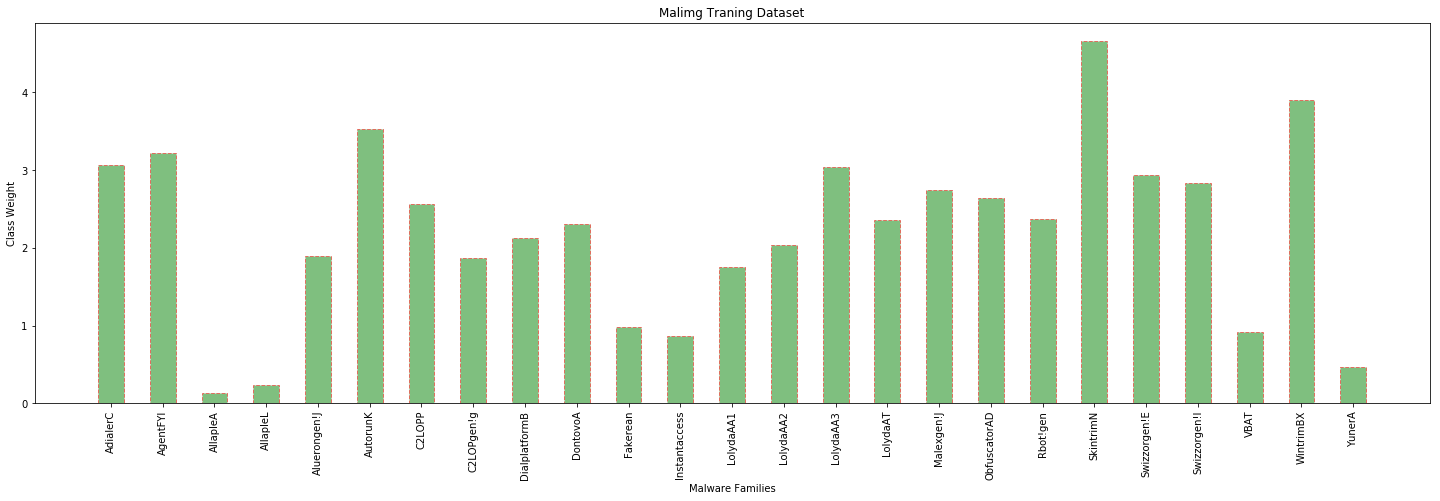

In [21]:
objects = class_labels#class_dictionary_train#cls_names_train#('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = class_weight_train#[10,8,6,4,2,1]
plt.figure(figsize = (25,7))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='g', linestyle='--', width=0.5, edgecolor='r', )
plt.xticks(y_pos, objects, rotation='vertical')
plt.xlabel('Malware Families')
plt.ylabel('Class Weight')
plt.title('Malimg Traning Dataset')
 
plt.show()

In [22]:
generator_test = datagen_test.flow_from_directory(directory=test_path,
                                                  target_size=input_shape,
                                                  class_mode='categorical',
                                                  color_mode="rgb",
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  seed=42)

steps_test = generator_test.n / batch_size
steps_test
print("Steps for Test",steps_test)

cls_test = generator_test.classes
print(cls_test)
cls_names_test = list(generator_test.class_indices.keys())
print(cls_names_test)
num_cls_test = len(cls_names_test)
print("Number of Classes in Test Data",num_cls_test)

Found 2812 images belonging to 25 classes.
Steps for Test 87.875
[ 0  0  0 ..., 24 24 24]
['AdialerC', 'AgentFYI', 'AllapleA', 'AllapleL', 'Aluerongen!J', 'AutorunK', 'C2LOPP', 'C2LOPgen!g', 'DialplatformB', 'DontovoA', 'Fakerean', 'Instantaccess', 'LolydaAA1', 'LolydaAA2', 'LolydaAA3', 'LolydaAT', 'Malexgen!J', 'ObfuscatorAD', 'Rbot!gen', 'SkintrimN', 'Swizzorgen!E', 'Swizzorgen!I', 'VBAT', 'WintrimBX', 'YunerA']
Number of Classes in Test Data 25


In [23]:
class_dictionary_test = generator_test.class_indices
class_dictionary_test

{'AdialerC': 0,
 'AgentFYI': 1,
 'AllapleA': 2,
 'AllapleL': 3,
 'Aluerongen!J': 4,
 'AutorunK': 5,
 'C2LOPP': 6,
 'C2LOPgen!g': 7,
 'DialplatformB': 8,
 'DontovoA': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'LolydaAA1': 12,
 'LolydaAA2': 13,
 'LolydaAA3': 14,
 'LolydaAT': 15,
 'Malexgen!J': 16,
 'ObfuscatorAD': 17,
 'Rbot!gen': 18,
 'SkintrimN': 19,
 'Swizzorgen!E': 20,
 'Swizzorgen!I': 21,
 'VBAT': 22,
 'WintrimBX': 23,
 'YunerA': 24}

In [24]:
from sklearn.utils.class_weight import compute_class_weight
class_weight_test = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_test),
                                    y=cls_test)

In [25]:
class_weight_test

array([ 3.04      ,  3.21371429,  0.12709605,  0.23531381,  1.87466667,
        3.515     ,  2.55636364,  1.87466667,  2.08296296,  2.2955102 ,
        0.97808696,  0.86523077,  1.7575    ,  2.00857143,  3.04      ,
        2.34333333,  2.74341463,  2.61581395,  2.34333333,  4.68666667,
        2.88410256,  2.812     ,  0.91447154,  3.74933333,  0.46866667])

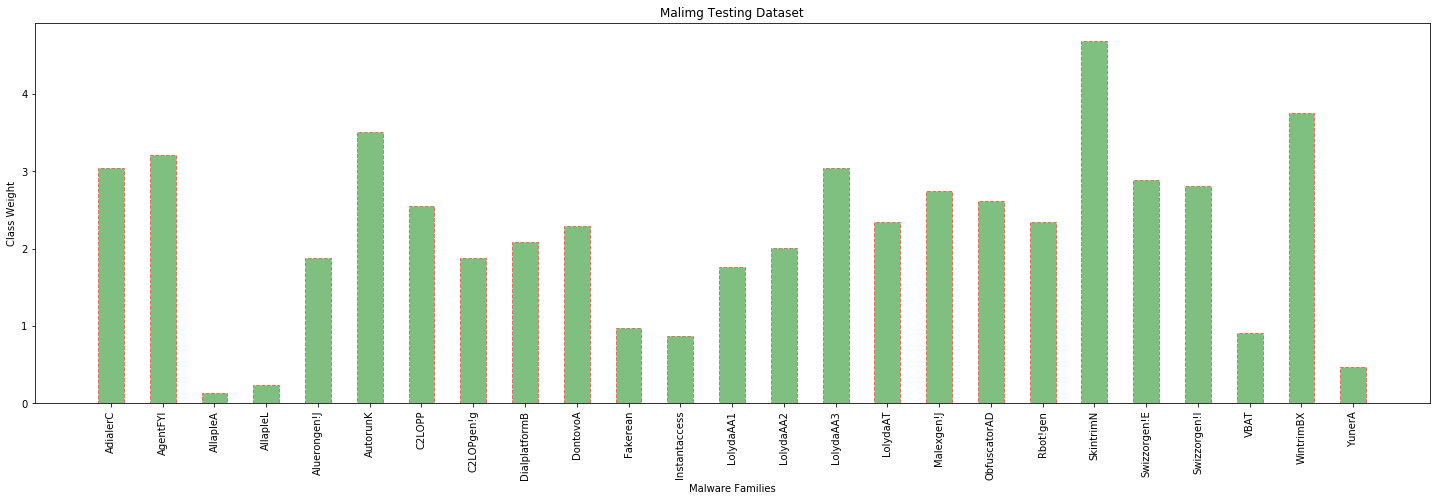

In [26]:
objects = class_labels#class_dictionary_train#cls_names_train#('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = class_weight_test#[10,8,6,4,2,1]
plt.figure(figsize = (25,7))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='g', linestyle='--', width=0.5, edgecolor='r', )
plt.xticks(y_pos, objects, rotation='vertical')
plt.xlabel('Malware Families')
plt.ylabel('Class Weight')
plt.title('Malimg Testing Dataset')
 
plt.show()

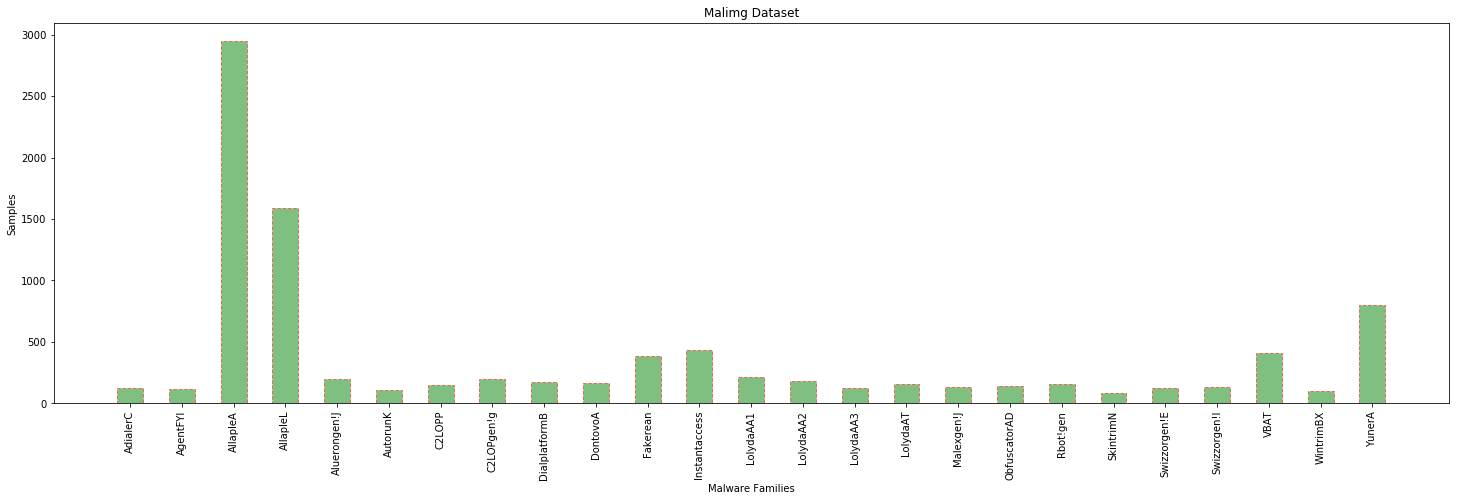

In [27]:
objects = class_labels#class_dictionary_train#cls_names_train#('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = [122,116,2949,1591,198,106,146,200,177,162,381,431,213,184,123,159,136,142,158,80,128,132,408,97,800]
plt.figure(figsize = (25,7))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='g', linestyle='--', width=0.5, edgecolor='r', )
plt.xticks(y_pos, objects, rotation='vertical')
plt.xlabel('Malware Families')
plt.ylabel('Samples')
plt.title('Malimg Dataset')
 
plt.show()

In [28]:
model_ = keras.applications.vgg16.VGG16()#include_top=True, weights=None, input_tensor=None, input_shape=(224,224,1), classes=num_cls_train)

In [29]:
transfer_layer = model_.get_layer('fc2')

In [30]:
transfer_layer.output

<tf.Tensor 'fc2/Relu:0' shape=(?, 4096) dtype=float32>

In [31]:
conv_model = Model(inputs=model_.input,
                   outputs=transfer_layer.output)

In [32]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [33]:
for layer in conv_model.layers:
    
    
    # Boolean whether this layer is trainable.
    trainable = ('fc1' in layer.name or 'fc2' in layer.name or 'block1' in layer.name or 'block2' in layer.name or 'block3' in layer.name or 'block4' in layer.name or 'block5' in layer.name) # or 'block6' in layer.name or 'block7' in layer.name or 'block8' in layer.name or 'block9' in layer.name or 'block10' in layer.name or 'block11' in layer.name or 'block12' in layer.name or 'block13' in layer.name or 'block14' in layer.name)
    
    if trainable:
        layer.trainable = False #trainable
        #print("False")
        
    trainable_ = ('fc1' in layer.name or 'fc2' in layer.name or 'block5' in layer.name) #or 'block5' in layer.name or 'block6' in layer.name or 'block7' in layer.name or 'block8' in layer.name or 'block9' in layer.name or 'block10' in layer.name or 'block11' in layer.name or 'block12' in layer.name or 'block13' in layer.name or 'block14' in layer.name)
    
    if trainable_:
        # Set the layer's bool.
        layer.trainable = trainable_
        print(trainable_)

True
True
True
True
True
True


In [34]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool
True:	flatten
True:	fc1
True:	fc2


In [35]:
# Start a new Keras Sequential model.
model = Sequential()

# Add the convolutional part of the VGG16 model from above.
model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
#model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
#model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
model.add(Dropout(0.5))

# Add the final layer for the actual classification.
model.add(Dense(num_cls_train, activation='softmax'))

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 4096)              134260544 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                102425    
Total params: 134,362,969
Trainable params: 126,727,705
Non-trainable params: 7,635,264
_________________________________________________________________


In [37]:

#model.load_weights('Deep_Learning_Model_for_Malimg_size=(192, 192)_Weights.hdf5')
model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])


In [38]:
epochs =10
steps_per_epoch=steps_train

In [39]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import RemoteMonitor



history = model.fit_generator(generator=generator_train,
                                epochs=epochs,
                                steps_per_epoch=steps_per_epoch,
                                validation_data=generator_test,
                                validation_steps=steps_test
                                )




Epoch 1/10
204/203 [==============================] - 76s 374ms/step - loss: 0.4821 - acc: 0.8802 - val_loss: 0.1176 - val_acc: 0.9587
Epoch 2/10
204/203 [==============================] - 65s 317ms/step - loss: 0.1127 - acc: 0.9646 - val_loss: 0.0965 - val_acc: 0.9694
Epoch 3/10
204/203 [==============================] - 65s 319ms/step - loss: 0.0721 - acc: 0.9736 - val_loss: 0.0730 - val_acc: 0.9797
Epoch 4/10
204/203 [==============================] - 63s 309ms/step - loss: 0.0533 - acc: 0.9804 - val_loss: 0.0518 - val_acc: 0.9829
Epoch 5/10
204/203 [==============================] - 65s 319ms/step - loss: 0.0476 - acc: 0.9828 - val_loss: 0.0812 - val_acc: 0.9744
Epoch 6/10
204/203 [==============================] - 65s 318ms/step - loss: 0.0321 - acc: 0.9884 - val_loss: 0.0768 - val_acc: 0.9733
Epoch 7/10
204/203 [==============================] - 65s 318ms/step - loss: 0.0254 - acc: 0.9902 - val_loss: 0.0661 - val_acc: 0.9826
Epoch 8/10
204/203 [==============================] - 6

In [3]:

# read Traning History back from the file
pkl_file = open("No-Aug-Color-History.pkl", 'rb')
history = pickle.load(pkl_file)
pkl_file.close()

In [4]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history) 

csv_file = 'No-Aug-Color-History.csv'
with open(csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [43]:
#scores = model.evaluate(X[test], Y[test], verbose=0)
#model.load_weights('Model_VGG16_Malimg_RGB_Trained_(229, 229)_Epochs=100_Model_Traning_Testing_Weights.hdf5')
scores = model.evaluate_generator(generator_test, verbose=1)# steps_test, max_queue_size=10, workers=1, use_multiprocessing=False,verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

88/88 [==============================] - 19s 215ms/step
acc: 98.40%


In [44]:
cls_pred = model.predict_generator(generator_test, verbose=1)#, steps_test, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)

88/88 [==============================] - 20s 222ms/step


In [45]:
cls_pred = np.argmax(cls_pred, axis=1)

In [46]:
y_test = cls_test = generator_test.classes

from pycm import ConfusionMatrix
CM_IMCFN = ConfusionMatrix(y_test,cls_pred)
file = open('CM-No-Aug-Color.pkl', 'wb')
pickle.dump(CM_IMCFN, file)
file.close()

In [47]:
# write Traning History to a file
file = open('CM-No-Aug-Color.pkl', 'rb')
CM_IMCFN = pickle.load(file)
file.close()

In [48]:
CM_IMCFN.stat(summary=True)

Overall Statistics : 

ACC Macro                                                         0.99872
F1 Macro                                                          0.95081
Kappa                                                             0.98126
Overall ACC                                                       0.984
PPV Macro                                                         0.9651
SOA1(Landis & Koch)                                               Almost Perfect
TPR Macro                                                         0.95728
Zero-one Loss                                                     45

Class Statistics :

Classes                                                           0             1             10            11            12            13            14            15            16            17            18            19            2             20            21            22            23            24            3             4             5             6    

/home/danish/anaconda3/envs/tf/lib/python3.6/site-packages/pycm/pycm_obj.py:167: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
The save_csv method can be used to save the confusion matrix in csv format and have a better demonstration of it.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


In [49]:
CM_IMCFN.save_csv("CM-No-Aug-Color",address=True)

{'Status': True,
 'Message': '/data/danish/ImgProPython/TensorFlow-Tutorials/Computer-Networks-(CCF-B)/No-Aug-Color/CM-No-Aug-Color.csv'}

In [50]:
%%time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
cls_true = cls_test = generator_test.classes
accuracy = accuracy_score(cls_true, cls_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(cls_true, cls_pred, average=None)

print("All Classes")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

All Classes
Precision:  [ 1.          1.          0.99887133  1.          1.          1.
  0.80769231  0.9047619   1.          1.          1.          1.
  0.98461538  1.          1.          1.          0.975       1.          1.
  1.          0.6         0.88888889  1.          0.96774194  1.        ]
Recall:  [ 1.          1.          1.          1.          1.          1.
  0.95454545  0.95        1.          1.          1.          1.          1.
  0.98214286  1.          1.          0.95121951  1.          0.97916667
  1.          0.92307692  0.2         0.99186992  1.          1.        ]
F1 score:  [ 1.          1.          0.99943535  1.          1.          1.          0.875
  0.92682927  1.          1.          1.          1.          0.99224806
  0.99099099  1.          1.          0.96296296  1.          0.98947368
  1.          0.72727273  0.32653061  0.99591837  0.98360656  1.        ]
CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 10.4 ms


In [51]:
%%time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
cls_true = cls_test = generator_test.classes
accuracy = accuracy_score(cls_true, cls_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(cls_true, cls_pred, average='micro')

print("Micro")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

Micro
Precision:  0.98399715505
Recall:  0.98399715505
F1 score:  0.98399715505
CPU times: user 5.06 ms, sys: 94 µs, total: 5.15 ms
Wall time: 4.76 ms


In [52]:
%%time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
cls_true = cls_test = generator_test.classes
accuracy = accuracy_score(cls_true, cls_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(cls_true, cls_pred, average='macro')

print("Macro")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

Macro
Precision:  0.965102870131
Recall:  0.957280853293
F1 score:  0.950810743199
CPU times: user 4.57 ms, sys: 49 µs, total: 4.62 ms
Wall time: 4.15 ms


In [53]:
%%time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
cls_true = cls_test = generator_test.classes
accuracy = accuracy_score(cls_true, cls_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(cls_true, cls_pred, average='weighted')

print("weighted")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

weighted
Precision:  0.986416608367
Recall:  0.98399715505
F1 score:  0.981513742877
CPU times: user 5.43 ms, sys: 0 ns, total: 5.43 ms
Wall time: 4.82 ms
